In [1]:
# ==================================================================================
# Function: Read EAP matrix, extract EAP features and run EAP feature clusters
# The code reproduces Fig.2d
# @Author: Yina Wei, 2021
#==================================================================================
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from time import time
from scipy import stats
import ecp_func as ef # import self-written sub functions  

plt.rcParams.update({'font.size': 9})
sns.set_style("whitegrid", {'axes.grid' : False})
my_pal_FSRS = {0:[5/255.0,23/255.0,182/255.0],1:[23/255.0,163/255.0,95/255.0],2:[213/255.0,9/255.0,21/255.0],3:[254/255.0,200/255.0,46/255.0]}
fs_pal=['steelblue','seagreen','mediumpurple']
rs_pal=['crimson','darkorange','saddlebrown']

In [2]:
# The set of parameters 


## Load  EAP waveform

In [3]:
# File paths
path = 'data/wt_EAP_data_info/'
savedir='data/wt_EAP_data_info/'
savefigdir='Figures/'

# session_id 
session_id=[732592105,739448407,744228101,750332458,750749662,754312389,754829445,757216464,757970808,759883607,761418226,
 763673393,766640955,767871931,768515987,771160300,771990200,774875821,778240327,778998620,779839471,781842082,793224716,799864342,847657808]

unit_num = np.zeros(len(session_id))
for i in range(len(session_id)):
    with open(path+str(session_id[i])+'.npy', 'rb') as np_file: # EAP waveform
        data=np.load(np_file)
        unit_num[i]=data.shape[0]
        if i==0:
            waveform0=data
        else:
            waveform0=np.concatenate((waveform0,data))
print(waveform0.shape)
print(unit_num)
[N,T,channels]=waveform0.shape
print(len(session_id))

(1313, 82, 40)
[75. 16. 27. 42. 36. 73. 53. 62. 47. 40. 32. 62. 36. 84. 58. 67. 41. 52.
 68. 49. 96. 58. 54. 53. 32.]
25


In [4]:
fr0 = []
depth0 = []
unit_id0 =[]
good0=[]
for i in range(len(session_id)):
    data = pd.read_csv(path+str(session_id[i])+'unitinfo.csv',index_col=0)
   # print len(data['fr'])
    fr0.append(data['fr_5min'])
    depth0.append(data['depth'])
    unit_id0.append(data['units'])
    good0.append(data['good'])
fr0 = np.array(np.concatenate(fr0))
depth0 = np.array(np.concatenate(depth0))
good0= np.array(np.concatenate(good0))
unit_id0= np.array(np.concatenate(unit_id0))

bad_unit = np.array([915960371, 915961088, 915960802, 915960838, 951868026, 951868229,951868527, 951869594, 951816073, 951002808, 951814989, 951815653,
                     951815724,951815709, 951816276, 951816492, 951877391, 951796229,951768170,951013844,951026044,951027930,951896781,951896911,951800909,950938909,
                     950935800,950929267,950927995,950935732,950929283,950930487,950931566,951801768,951762773,951095926,951768557,950928046])

for i in range(len(unit_id0)):
    if unit_id0[i] in bad_unit:
        good0[i]=0

good = np.where(good0==1.0)[0]
fr0=fr0[good]
depth0=depth0[good]
unit_id0=unit_id0[good]
waveform=waveform0[good,:,:]
[N,T,channels]=waveform.shape
print(len(fr0))
print(N)

1287
1287


In [5]:
eleRowN = int(channels/2)
print(eleRowN)
sampling_rate=30000 #sampleing rate is 30kHz
fs=sampling_rate
dt=1.0/sampling_rate
t_STA=np.array(range(0,T))*dt*1000-0.6 
Th=5
dist=np.array(range(-100,101,20))
print(dist)

20
[-100  -80  -60  -40  -20    0   20   40   60   80  100]


## Calculate EAP features

In [6]:
features0=np.zeros((len(dist),len(good),4))     # dist*num_cells*num_features  #dist only includes -100,-80,-60,-40,-20,0,20,40,60,80,100
all_features0 = np.zeros((len(good),11))        # each cell has 11 features
max_waveform0 = np.zeros((len(good),T))         # save the maximal EAP waveform
norm_oneColEAP = {}
badch=[]
saveEAP = 0 # 0: dont save EAP, 1: save EAP 
for num in range(len(unit_id0)):

    EAP=waveform[num,:,:]  # amplify =0.195, the EAP of the index[k] cell 
    dist0 = np.zeros((eleRowN,1))
    
    #Select the one column
    oneCol_EAP = np.zeros((eleRowN,T))  # channels * times -- one column
    for i in range(0,eleRowN):
        temp0 = ef.butter_highpass_filter(np.transpose(EAP[:,i*2]),300,fs)  # even index
        oneCol_EAP[i,:]= temp0
        dist0[i]=i*20    
    
    # dist = 0, the channel cloest to soma, which have the largest negative peak
    maxCh = 10
    maxCh0=np.unravel_index(oneCol_EAP.argmin(),oneCol_EAP.shape)[0]
    if maxCh0!=10:
        badch.append(num)
    dist0 = np.squeeze(dist0)- dist0[maxCh]
    indx = np.where(np.logical_and(dist0>=-100,dist0<=100))[0]
    
    if saveEAP==1:
        f=1/abs(min(oneCol_EAP[maxCh,:]))*3

        fig, ax = plt.subplots(figsize=(2.5*0.46,3.8*0.5))
        ax=plt.subplot(111)
        for i in range(maxCh-7,maxCh+8): 
            if i==maxCh:
                plt.plot(t_STA,oneCol_EAP[i,:]*f+i,color='grey',linewidth='2') 
            elif abs(min(oneCol_EAP[i,:]))>=abs(min(oneCol_EAP[maxCh,:]))*0.12:
                plt.plot(t_STA,oneCol_EAP[i,:]*f+i,color='grey',linewidth='1') 
            else:
                plt.plot(t_STA,oneCol_EAP[i,:]*f+i,color='grey',linewidth='1') 
        plt.yticks([])
        plt.xticks([])
        simpleaxis_all(ax)
        plt.title(str(unit_id0[num]),fontsize=9)
        fig.savefig(savedir+'EAP/'+str(unit_id0[num])+'.eps',bbox_inches = 'tight')
        fig.savefig(savedir+'EAP/'+str(unit_id0[num])+'.pdf',bbox_inches = 'tight')
        plt.close()
   
    #Extract EAP features
    #Extract featrues based on EAP data as the distance changes
    A,W,TPW,t_NegPeak=ef.cal_EAP_features(t_STA,oneCol_EAP,0.01)       #oneCol_VeSTA,channels*times    
    t_NegPeak = t_NegPeak-t_NegPeak[maxCh]  # set the maximal channel as 0
    
    norm_oneColEAP[unit_id0[num]]=oneCol_EAP/max(A)
    
    # Preprocess the data of A,W,TPW,t_NegPeak, deal with unphysiological values
    dth = 100  
    idx_below = np.where(np.logical_and(np.logical_and(dist0<=0,dist0>=-dth),A>=0.0001))[0]
    idx_above = np.where(np.logical_and(np.logical_and(dist0>=0,dist0<=dth),A>=0.0001))[0]
        
    W[idx_below]=ef.outlier_below(dist0[idx_below],W[idx_below],0.3)
    W[idx_above]=ef.outlier_above(dist0[idx_above],W[idx_above],0.3)
    TPW[idx_below]=ef.outlier_below(dist0[idx_below],TPW[idx_below],0.3)
    TPW[idx_above]=ef.outlier_above(dist0[idx_above],TPW[idx_above],0.3)
    t_NegPeak[idx_below]=ef.outlier_below(dist0[idx_below],t_NegPeak[idx_below],0.3)
    t_NegPeak[idx_above]=ef.outlier_above(dist0[idx_above],t_NegPeak[idx_above],0.3)     
    
    features0[:,num,0]=A[indx]
    features0[:,num,1]=W[indx]
    features0[:,num,2]=TPW[indx]
    features0[:,num,3]=t_NegPeak[indx]
    
    #one-channel-features:'A','W','TPW','PTratio','REP'
    max_waveform0[num,:] = oneCol_EAP[maxCh,:]/abs(min(oneCol_EAP[maxCh,:]))
    max_waveform0[num,:] = max_waveform0[num,:]-max_waveform0[num,0]
    one_channel_feature  = ef.cal_one_ch_features(t_STA,oneCol_EAP[maxCh,:])

    # multi-channel-features:'spread_below','spread_above','W_below','W_above','PL_below','PL_above'
    dth = 100
    spread_below,spread_above,W_below,W_above,PL_below,PL_above,intercept0,intercept1,intercept4,intercept5=ef.cal_multi_ch_features(dist0,A,W,t_NegPeak,maxCh,dth,Th,0.005,3)
    all_features0[num,:]=one_channel_feature+[spread_below,spread_above,W_below,W_above,PL_below,PL_above] # one channel features + multiple channel features

In [7]:
allindex = np.arange(len(all_features0))

neg_time=[]
for i in range(len(max_waveform0)):
    neg_time.append(ef.find_neg_peak_time(max_waveform0[i,:],t_STA))
    
outlier=np.unique(np.concatenate([ef.outlier_index(all_features0[:,1]),ef.outlier_index(all_features0[:,2]),ef.outlier_index(all_features0[:,4]),ef.outlier_index(all_features0[:,7]),ef.outlier_index(all_features0[:,8]),ef.outlier_index(all_features0[:,9]),ef.outlier_index(all_features0[:,10])]))
remove_indices = np.unique(np.concatenate([badch,outlier,np.where(abs(np.array(neg_time))>0.1)[0],np.where(all_features0[:,0]<15)[0],np.where(all_features0[:,0]>300)[0]]))

allindex = np.arange(len(all_features0))
index0 = np.setxor1d(np.indices(allindex.shape), remove_indices)

all_features = all_features0[index0,:]
features = features0[:,index0,:]
max_waveform = max_waveform0[index0,:]

FR = fr0[index0]
depth_info = depth0[index0]
unit_id = unit_id0[index0]

print(len(index0))

1204


In [8]:
df0 = pd.DataFrame(all_features,columns=['A','W','TPW','PTratio','REP','spread_below','spread_above','W_below','W_above','PL_below','PL_above'])
df0.insert(0, column='Spread',value=df0['spread_above'].values+df0['spread_below'].values)
df0.insert(0, column='Diff_spread',value=df0['spread_above'].values-df0['spread_below'].values)
df0.insert(0, column='FR',value=FR)
PL_dist=ef.sym_dist_fc(df0['PL_below'].values,df0['PL_above'].values)

## Clustering between FS and RS based on one-channel features

In [9]:
X_r = df0[['TPW','REP']].values   # one-channel features
X_r2 = ef.pre_process(X_r)

numk=9
[K2,wcss2,fk2] = ef.selectionK_kmeans(X_r2,numk) # calculate elbow method and density function
elbow_idx2  = ef.findElbow(wcss2)

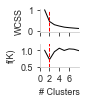

In [10]:
fig, ax = plt.subplots(figsize=(0.64,1.2*0.8))
ax=plt.subplot(211)
#Plotting the Elbow Curve by k(number of clusters)
plt.plot(K2,wcss2/max(wcss2),'k-',markerfacecolor='None',linewidth=1)
plt.plot([K2[elbow_idx2],K2[elbow_idx2]],[0,1],'r--',linewidth=1)
plt.ylabel('WCSS')
#plt.title('Elbow Method',fontsize=9)
ef.simpleaxis(ax)
plt.xlim(0,8)
ax.set_xticklabels([])
ax.set_xticks(range(0,8,2))
ax=plt.subplot(212)
#Plotting the Density Function fk by k(number of clusters)
plt.plot(K2,fk2,'k-',markerfacecolor="None",linewidth=1)
plt.plot([K2[fk2.argmin()],K2[fk2.argmin()]],[0,1.5],'r--',linewidth=1)
plt.xlabel('# Clusters')
plt.ylabel('f(K)')
#plt.title('Density Function')
ef.simpleaxis(ax)
plt.xlim(0,8)
ax.set_xticks(range(0,8,2))
plt.ylim(0.5,1.2)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.5)

In [11]:
# K-means
kmeans2 = KMeans(init='k-means++',n_clusters=2,n_init=1000,random_state=11400)
kmeans2.fit(X_r2)
label2 =  kmeans2.labels_
print(label2)

print(len(np.where(label2==0)[0]))
print(len(np.where(label2==1)[0]))

if 'cell_type' in df0.keys():
    df0=df0.drop(columns=['cell_type'])
df0.insert(0, column="cell_type",value = label2)

[1 1 1 ... 1 0 0]
281
923


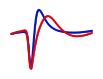

In [12]:
fig, ax = plt.subplots(figsize=(3.5,1.2))
ax =plt.subplot(122)
ef.plot_shaded_errorbar(ax,t_STA,max_waveform[label2==0,:],my_pal_FSRS[0])
ef.plot_shaded_errorbar(ax,t_STA,max_waveform[label2==1,:],my_pal_FSRS[2])
ax.axis('tight')
ef.clean_axis(ax)
#plt.xlabel('Time (ms)')

(0.05, 0.6)

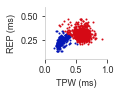

In [13]:
fig, ax = plt.subplots(figsize=(1.6*0.7,1.2*0.8))
ax.scatter(all_features[label2==1,2],all_features[label2==1,4], color=my_pal_FSRS[2],s=1,label='RS')
ax.scatter(all_features[label2==0,2],all_features[label2==0,4], color=my_pal_FSRS[0],s=1,label='FS')
plt.xlabel('TPW (ms)')
plt.ylabel('REP (ms)')
ef.simpleaxis(ax)
plt.xlim([0,1])
plt.ylim([0.05,0.6])

## Further Clustering FS into FS1,FS2,FS3, and RS into RS1,RS2,RS3

In [14]:
X_r_sub = df0[['PL_below','PL_above']].values   # Multichannel features
Multi_X_r=ef.pre_process(X_r_sub)

In [15]:
X_r_sub0 = Multi_X_r[label2==0,:]
idx_sub0 = np.where(label2==0)[0]

X_r_sub1 = Multi_X_r[label2==1,:]
idx_sub1 = np.where(label2==1)[0]

numk=9
[K0,wcss0,fk0] = ef.selectionK_kmeans(X_r_sub0,numk)
elbow_idx0  = ef.findElbow(wcss0)

[K1,wcss1,fk1] = ef.selectionK_kmeans(X_r_sub1,numk)
elbow_idx1  = ef.findElbow(wcss1)

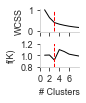

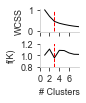

In [16]:
fig, ax = plt.subplots(figsize=(0.64,1.2*0.8))
ax=plt.subplot(211)
#Plotting the Elbow Curve by k(number of clusters)
plt.plot(K0,wcss0/max(wcss0),'k-',markerfacecolor='None',linewidth=1)
plt.plot([K0[elbow_idx0],K0[elbow_idx0]],[0,1],'r--',linewidth=1)
plt.ylabel('WCSS')
#plt.title('Elbow Method',fontsize=9)
ef.simpleaxis(ax)
plt.xlim(0,8)
ax.set_xticklabels([])
ax.set_xticks(range(0,8,2))
ax=plt.subplot(212)
#Plotting the Density Function fk by k(number of clusters)
plt.plot(K0,fk0,'k-',markerfacecolor="None",linewidth=1)
plt.plot([K0[fk0.argmin()],K0[fk0.argmin()]],[0,1.5],'r--',linewidth=1)
plt.xlabel('# Clusters')
plt.ylabel('f(K)')
ef.simpleaxis(ax)
plt.xlim(0,8)
ax.set_xticks(range(0,8,2))
plt.ylim(0.8,1.2)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.5)

fig, ax = plt.subplots(figsize=(0.64,1.2*0.8))
ax=plt.subplot(211)
#Plotting the Elbow Curve by k(number of clusters)
plt.plot(K1,wcss1/max(wcss1),'k-',markerfacecolor='None',linewidth=1)
plt.plot([K1[elbow_idx1],K1[elbow_idx1]],[0,1],'r--',linewidth=1)
plt.ylabel('WCSS')
#plt.title('Elbow Method',fontsize=9)
ef.simpleaxis(ax)
plt.xlim(0,8)
ax.set_xticklabels([])
ax.set_xticks(range(0,8,2))
ax=plt.subplot(212)
#Plotting the Density Function fk by k(number of clusters)
plt.plot(K1,fk1,'k-',markerfacecolor="None",linewidth=1)
plt.plot([K1[fk1.argmin()],K1[fk1.argmin()]],[0,1.5],'r--',linewidth=1)
plt.xlabel('# Clusters')
plt.ylabel('f(K)')
#plt.title('Density Function')
ef.simpleaxis(ax)
plt.xlim(0,8)
ax.set_xticks(range(0,8,2))
plt.ylim(0.8,1.2)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.5)

In [17]:
nc0=fk0.argmin()+1
nc1=fk1.argmin()+1

In [18]:
# K-means
kmeans_sub0 = KMeans(init='k-means++',n_clusters=nc0,n_init=1000,random_state=110)
kmeans_sub0.fit(X_r_sub0)
label_sub0 =  kmeans_sub0.labels_
#print(label_sub0)

kmeans_sub1 = KMeans(init='k-means++',n_clusters=nc1,n_init=1000,random_state=1001)
kmeans_sub1.fit(X_r_sub1)
label_sub1 =  kmeans_sub1.labels_
#print(label_sub1)

(-4.0, 7.0)

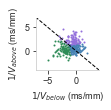

In [19]:
fig, ax = plt.subplots(figsize=(1.4*0.8,1.2*0.8))

for i in range(nc0):
    ax.scatter(all_features[idx_sub0[label_sub0==i],9],all_features[idx_sub0[label_sub0==i],10], color=fs_pal[i],s=1,label='RS')
plt.xlabel('$1/V_{below}$ (ms/mm)')
plt.ylabel('$1/V_{above}$ (ms/mm)')
ef.simpleaxis(ax)
plt.plot([-10,10],[10,-10],'--',color='black',linewidth=1)
plt.xlim([-7,4])
plt.ylim([-4,7])

(-4.0, 7.0)

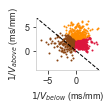

In [20]:
fig, ax = plt.subplots(figsize=(1.4*0.8,1.2*0.8))

for i in range(nc1):
    ax.scatter(all_features[idx_sub1[label_sub1==i],9],all_features[idx_sub1[label_sub1==i],10], color=rs_pal[i],s=1,label='RS')
plt.xlabel('$1/V_{below}$ (ms/mm)')
plt.ylabel('$1/V_{above}$ (ms/mm)')
ef.simpleaxis(ax)
plt.plot([-10,10],[10,-10],'--',color='black',linewidth=1)
plt.xlim([-7,4])
plt.ylim([-4,7])

In [21]:
nf=features[:,:,3]
z=nf.copy()
z[~np.isnan(nf)]=stats.zscore(nf[~np.isnan(nf)])

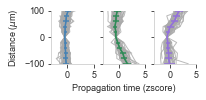

In [22]:
my_pal=fs_pal
fig, ax = plt.subplots(figsize=(3.7*0.8*0.8,1.1*0.8))
for i in range(nc0):    
    ax =plt.subplot(1,3,i+1)
    dpl0 = np.ma.masked_array(np.squeeze(z[:,idx_sub0[label_sub0==i]]),np.squeeze(features[:,idx_sub0[label_sub0==i],0])<Th)
    ef.plot_errorbar_vertical(ax,dist,np.transpose(dpl0),my_pal[i]) 
    plt.plot(dpl0,dist,'darkgrey',zorder=-10,alpha=0.8,linewidth=1)
    plt.ylim([-100,100])
    ax.set_xlim([-3,5])
    if i==1:
        plt.xlabel('Propagation time (zscore)')
    if i==0:
        plt.ylabel('Distance (${\mu}$m)')
    else:
        ax.set_yticklabels([])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1,
                wspace=0.2)       

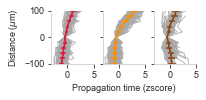

In [23]:
my_pal=rs_pal
fig, ax = plt.subplots(figsize=(3.7*0.8*0.8,1.1*0.8))
for i in range(nc1):    
    ax =plt.subplot(1,3,i+1)
    dpl0 = np.ma.masked_array(np.squeeze(z[:,idx_sub1[label_sub1==i]]),np.squeeze(features[:,idx_sub1[label_sub1==i],0])<Th)
    ef.plot_errorbar_vertical(ax,dist,np.transpose(dpl0),my_pal[i]) 
    plt.plot(dpl0,dist,'darkgrey',zorder=-10,alpha=0.8,linewidth=1)
    plt.ylim([-100,100])
    ax.set_xlim([-3,5])
    if i==1:
        plt.xlabel('Propagation time (zscore)')
    if i==0:
        plt.ylabel('Distance (${\mu}$m)')
    else:
        ax.set_yticklabels([])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1,
                wspace=0.2)    

In [24]:
label_new = np.zeros(len(FR))
for i in range(nc0):
    label_new[idx_sub0[label_sub0==i]]=i
for i in range(nc1):
    label_new[idx_sub1[label_sub1==i]]=nc0+i
print(np.unique(label_new))

df = df0.copy()#pd.DataFrame(all_features,columns=['A','W','TPW','PTratio','REP','Spread','Diff_spread','W_below','W_above','PL_below','PL_above'])
df.insert(0, column="cell_type0",value = label_new)
df.insert(0,column='depth',value=depth_info)
df.insert(0,column='unit_id',value=unit_id)
#df.to_csv('data/exp_features.csv') #79

[0. 1. 2. 3. 4. 5.]
